## Setup

In [ ]:
## Install Hugging Face Libraries
!pip install -U datasets==3.6.0 huggingface_hub==0.34.0 fsspec==2025.3.0

## Install Additional Hugging Face for Finetuning (PEFT AND TRL)
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf hf_transfer

## Install Unsloth for Downloading Model annd Optimizing training Speed and Memory
!pip install --no-deps unsloth

## For calculating Metrics
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.7/558.7 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.34.4
    Uninstalling huggingface-hub-0.34.4:
      Successfully uninstalled huggingface-hub-0.34.4
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 30.5 MB/s eta 0:00:00
  Prepa

## Imports

In [ ]:
import difflib
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import random

from unsloth import FastLanguageModel
from unsloth import FastModel

import torch
from huggingface_hub import login
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments
from transformers import pipeline
from trl import SFTConfig, SFTTrainer
from trl import GRPOConfig, GRPOTrainer

from rouge_score import rouge_scorer

In [ ]:
## Authenticate Hugging Face
token = input("Enter The token")
login(token=token)

## EDA

In [ ]:
# Load the dataset
dataset = load_dataset("gretelai/synthetic_text_to_sql", revision='main')

README.md: 0.00B [00:00, ?B/s]

(…)nthetic_text_to_sql_train.snappy.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

(…)ynthetic_text_to_sql_test.snappy.parquet:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5851 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 5851
    })
})

In [ ]:
# Convert the dataset to a pandas DataFrame for easier exploration
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()

In [ ]:
print("Training data information:")
df_train.info()
print("\nTest data information:")
df_test.info()

Training data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   id                          100000 non-null  int32 
 1   domain                      100000 non-null  object
 2   domain_description          100000 non-null  object
 3   sql_complexity              100000 non-null  object
 4   sql_complexity_description  100000 non-null  object
 5   sql_task_type               100000 non-null  object
 6   sql_task_type_description   100000 non-null  object
 7   sql_prompt                  100000 non-null  object
 8   sql_context                 100000 non-null  object
 9   sql                         100000 non-null  object
 10  sql_explanation             100000 non-null  object
dtypes: int32(1), object(10)
memory usage: 8.0+ MB

Test data information:
<class 'pandas.core.frame.DataFrame'>
RangeInde

In [ ]:
# Display the first few rows of each dataset
print("\nFirst 5 rows of the training dataset:")
df_train.head()



First 5 rows of the training dataset:


,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...


In [ ]:
print("\nFirst 5 rows of the test dataset:")
df_test.head()


First 5 rows of the test dataset:


,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,1,artificial intelligence,"AI data on algorithmic fairness, AI safety, ex...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the average explainability score of cr...,"CREATE TABLE creative_ai (application_id INT, ...",SELECT AVG(explainability_score) FROM creative...,This SQL query calculates the average explaina...
1,2,rural development,"Agricultural innovation metrics, rural infrast...",basic SQL,basic SQL with a simple select statement,data manipulation,"inserting, updating, or deleting records",Delete all records of rural infrastructure pro...,"CREATE TABLE rural_infrastructure (id INT, pro...",DELETE FROM rural_infrastructure WHERE country...,This SQL query deletes all records of rural in...
2,3,aerospace,"Aircraft manufacturing data, satellite deploym...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",How many accidents have been recorded for Spac...,"CREATE TABLE Accidents (id INT, launch_provide...","SELECT launch_provider, COUNT(*) FROM Accident...",This query groups the Accidents table by the l...
3,4,aquaculture,"Aquatic farming data, fish stock management, o...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the maximum quantity of seafood sold i...,"CREATE TABLE sales (id INT, location VARCHAR(2...",SELECT MAX(quantity) FROM sales;,Find the maximum quantity of seafood sold in a...
4,5,entertainment industry,"Audience demographics, viewership trends, cont...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the total budget for movies released b...,"CREATE TABLE Movies_Release_Year (id INT, titl...",SELECT SUM(budget) FROM Movies_Release_Year WH...,This query calculates the total budget for mov...


In [ ]:
# Check the number of rows and columns
print("\nTraining dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)


Training dataset shape: (100000, 11)
Test dataset shape: (5851, 11)


In [ ]:
df_train.iloc[10]['sql_context'].split(";")

['CREATE TABLE farmers_india (id INT, name VARCHAR(255), district_id INT, age INT, income INT)',
 " INSERT INTO farmers_india (id, name, district_id, age, income) VALUES (1, 'Farmer A', 1, 45, 50000)",
 ' CREATE TABLE districts_india (id INT, name VARCHAR(255), state VARCHAR(255))',
 " INSERT INTO districts_india (id, name, state) VALUES (1, 'District A', 'Maharashtra')",
 '']

In [ ]:
def remove_insert_statements(sql_list):
    return ";".join([stmt.strip() for stmt in sql_list if 'insert into' not in stmt.lower() and stmt.strip()])

df_train['clean_sql_context'] = df_train['sql_context'].str.split(';').apply(remove_insert_statements)
df_test['clean_sql_context'] = df_test['sql_context'].str.split(';').apply(remove_insert_statements)


In [ ]:
df_train.iloc[10]['clean_sql_context'].split(";")

['CREATE TABLE farmers_india (id INT, name VARCHAR(255), district_id INT, age INT, income INT)',
 'CREATE TABLE districts_india (id INT, name VARCHAR(255), state VARCHAR(255))']

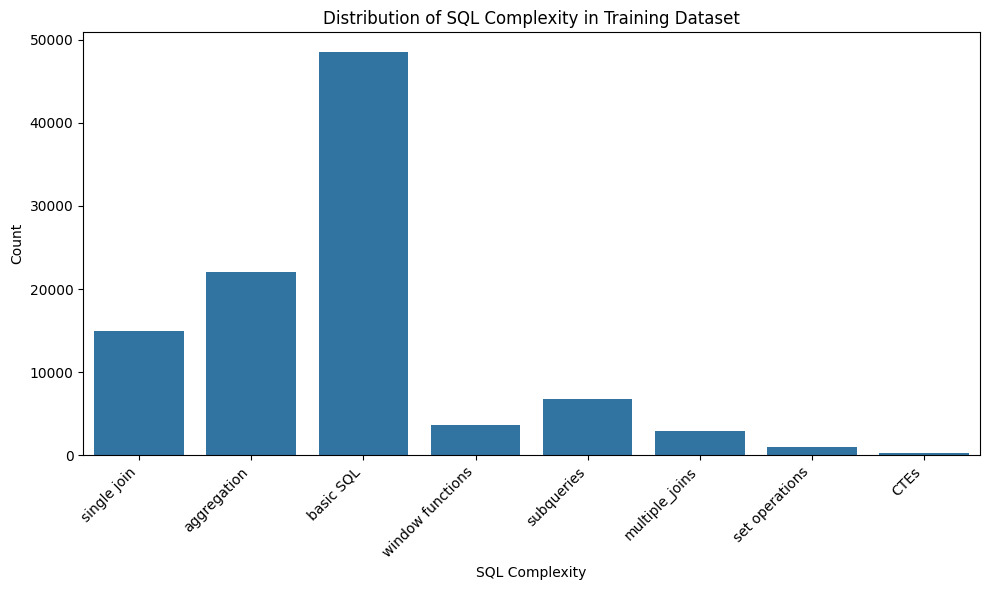

In [ ]:
# Plot the distribution of 'sql_complexity' in the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='sql_complexity')
plt.title('Distribution of SQL Complexity in Training Dataset')
plt.xlabel('SQL Complexity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

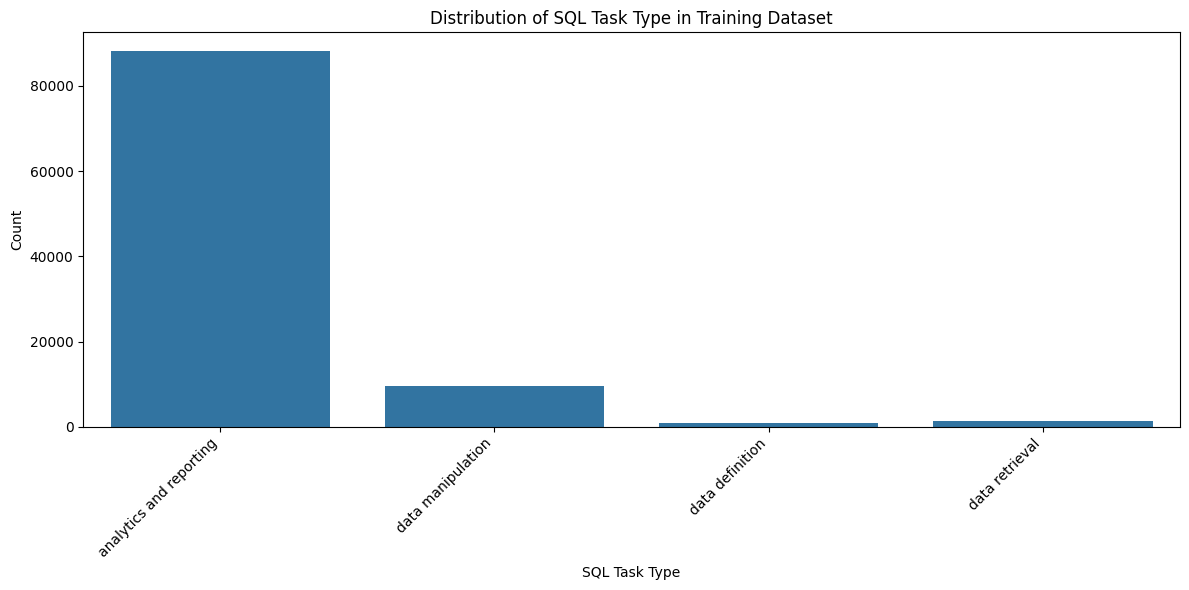

In [ ]:
# Plot the distribution of 'sql_task_type' in the training dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, x='sql_task_type')
plt.title('Distribution of SQL Task Type in Training Dataset')
plt.xlabel('SQL Task Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

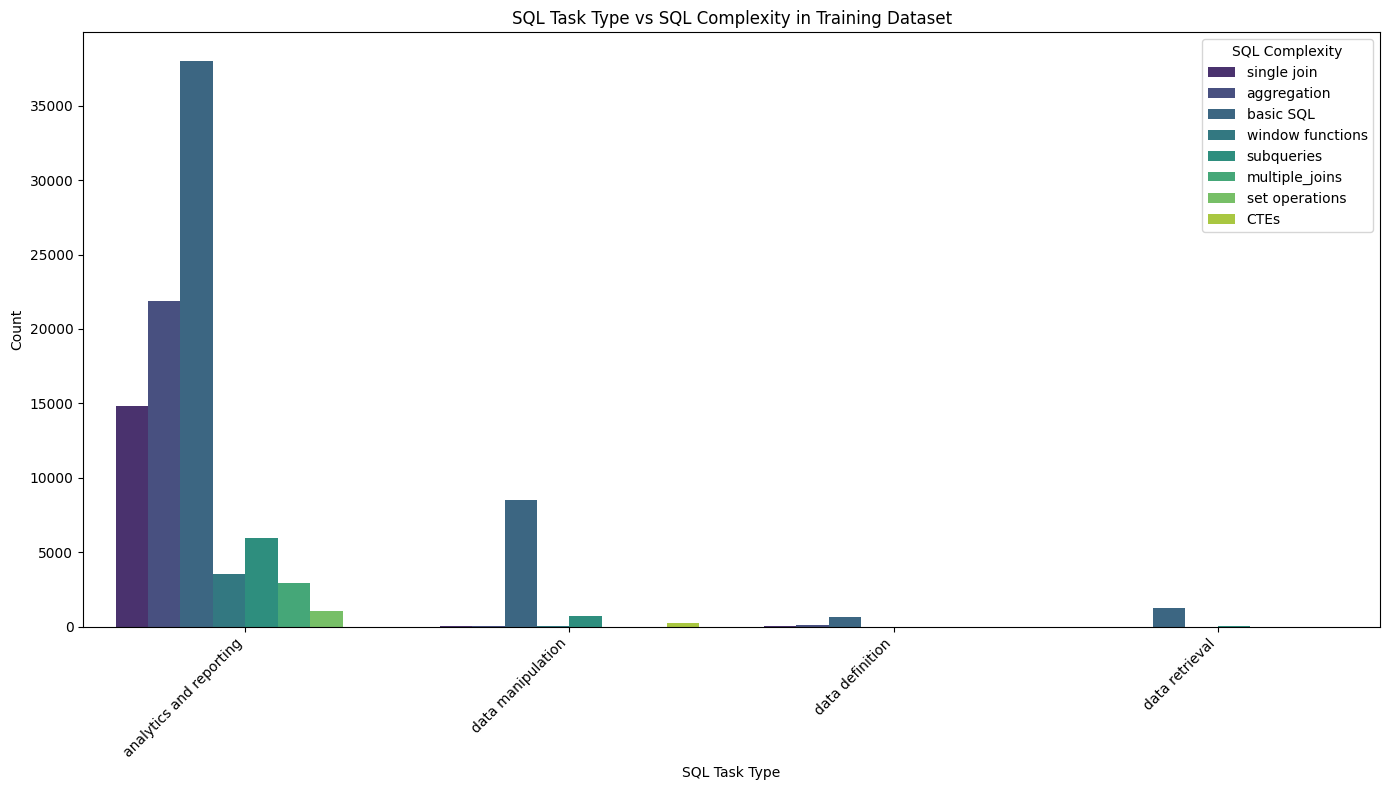

In [ ]:


# Look at the relationship between complexity and task type (optional)
plt.figure(figsize=(14, 8))
sns.countplot(data=df_train, x='sql_task_type', hue='sql_complexity', palette='viridis')
plt.title('SQL Task Type vs SQL Complexity in Training Dataset')
plt.xlabel('SQL Task Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='SQL Complexity')
plt.tight_layout()
plt.show()


## Model 1 : LLAMA 3.2

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B",
    max_seq_length = 512,
    load_in_4bit = True,
    full_finetuning = False,
)

==((====))==  Unsloth 2025.8.9: Fast Llama patching. Transformers: 4.55.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
peft_model = FastLanguageModel.get_peft_model(
    model,
    r = 16, #Rank
    random_state = 2000, #For Reproducibility
)

Unsloth 2025.8.9 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
# Create Dataset objects again from the pandas DataFrames since pre-processing has been done
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

updated_dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

updated_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context'],
        num_rows: 5851
    })
})

In [ ]:
##Prepare the Dataset
prompt = """### Instruction:
{}

Context:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    instructions = examples["sql_prompt"]
    contexts = examples["clean_sql_context"]
    outputs      = examples["sql"]
    texts = []
    for instruction,context ,output in zip(instructions, contexts ,outputs):
        # Must add EOS_TOKEN
        text = prompt.format(instruction, context, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

formatted_dataset = updated_dataset.map(formatting_prompts_func, batched = True)
formatted_dataset

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5851 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context', 'text'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context', 'text'],
        num_rows: 5851
    })
})

In [ ]:
#Sample Training Data

for i in range(1):
    pprint(formatted_dataset['test'][i]['text'])
    print("-" * 80)
    print ()

('### Instruction:\n'
 'What is the average explainability score of creative AI applications in '
 "'Europe' and 'North America' in the 'creative_ai' table?\n"
 '\n'
 'Context:\n'
 'CREATE TABLE creative_ai (application_id INT, name TEXT, region TEXT, '
 'explainability_score FLOAT)\n'
 '\n'
 '### Response:\n'
 "SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', "
 "'North America');<|end_of_text|>")
--------------------------------------------------------------------------------



In [ ]:
# Importing configuration and trainer classes from HuggingFace's trl library
# Initializing the trainer for supervised fine-tuning (SFT)
trainer = SFTTrainer(
    model = peft_model,                         # The model to be fine-tuned (e.g., a PEFT-wrapped LLM)
    tokenizer = tokenizer,                      # Tokenizer used to tokenize input text
    train_dataset = formatted_dataset["train"], # Training dataset
    eval_dataset = formatted_dataset["test"],   # Evaluation (validation) dataset
    dataset_text_field = "text",                # The field in the dataset that contains the text data
    max_seq_length = 512,                       # Maximum sequence length to tokenize (truncate longer input)
    dataset_num_proc = 2,                       # Number of parallel processes to use for dataset processing
    args = TrainingArguments(                   # Training arguments

        per_device_train_batch_size = 2,        # Number of examples per batch per GPU
        gradient_accumulation_steps = 4,        # Accumulate gradients over 4 steps (effective batch size = 2 * 4 = 8)

        learning_rate = 2e-4,                   # Hperparameter - Initial learning rate
        lr_scheduler_type = "linear",           # Use a linear learning rate scheduler
        optim = "adamw_8bit",                   # Use 8-bit AdamW optimizer for memory efficiency
        weight_decay = 0.01,                    # Hperparameter - Weight decay to prevent overfitting

        warmup_steps = 5,                       # Number of warmup steps for the learning rate scheduler
        max_steps = 60,                         # Total number of training steps (not epochs)
        logging_steps = 1,                      # Log training metrics every 1 step

        fp16 = True,                            # Use 16-bit floating point precision for faster training

        seed = 2000,                            # Random seed for reproducibility
        output_dir = "outputs",                 # Directory to save model checkpoints and logs
        report_to = "none",                     # Disable reporting to external tools (like wandb)
    ),
)


Unsloth: Tokenizing ["text"]:   0%|          | 0/100000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/5851 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Step,Training Loss
1,2.190100
2,2.108900
3,1.962500
4,2.204100
5,1.751000
6,1.512500
7,1.550500
8,1.399100
9,1.130500
10,1.141700


Unsloth: Will smartly offload gradients to save VRAM!


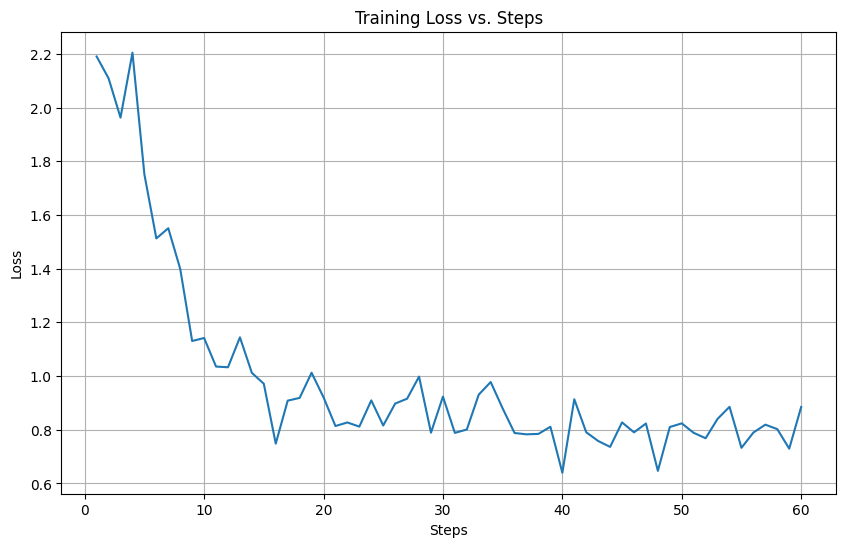

In [ ]:
# Plot the loss vs steps
plt.figure(figsize=(10, 6))
plt.plot([x["step"] for x in trainer.state.log_history if "loss" in x], [x["loss"] for x in trainer.state.log_history if "loss" in x])
plt.title('Training Loss vs. Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:

peft_model.save_pretrained("sql_fintuned_10")

### Model1: Inference

In [ ]:
# Load model and tokenizer using Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "sql_fintuned_10",
    max_seq_length = 512,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model)

# Create the generation pipeline
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)


==((====))==  Unsloth 2025.8.9: Fast Llama patching. Transformers: 4.55.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device set to use cuda:0


In [ ]:
# prompt: write code to predict on the test set and compare the results with actual and predicted by printing 10 random records from test

import random
import pandas as pd

def answer_question(question: str, context: str) -> str:
  """
  Generates an answer (SQL query) for a given question using the fine-tuned model.
  """
  formatted_prompt = prompt.format(question, context,"")
  response = generator(formatted_prompt, max_new_tokens=512)
  text_response = response[0]["generated_text"]
  return text_response.split("### Response:")[1].strip()

# Get 10 random indices from the test dataset
random.seed(42)
random_indices = random.sample(range(len(test_dataset)), 10)

results = []

print("Comparing Actual vs Predicted SQL Queries (10 Random Records from Test Set):")
print("-" * 100)

for i in random_indices:
    test_record = test_dataset[i]
    actual_sql = test_record['sql']
    question = test_record['sql_prompt']
    context = test_record['clean_sql_context']

    # Get the predicted SQL query
    predicted_sql = answer_question(question, context)

    print(f"Record Index: {i}")
    print(f"Prompt: {question}")
    print(f"Actual SQL: {actual_sql}")
    print(f"Predicted SQL: {predicted_sql}")
    print("-" * 100)

    results.append({
        'Record Index': i,
        'Prompt': question,
        'Actual SQL': actual_sql,
        'Predicted SQL': predicted_sql
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the DataFrame
print("\nResults DataFrame:")
display(results_df)

Comparing Actual vs Predicted SQL Queries (10 Random Records from Test Set):
----------------------------------------------------------------------------------------------------
Record Index: 5238
Prompt: How many smart city projects were completed in the US and Canada?
Actual SQL: SELECT COUNT(*) FROM smart_city_projects WHERE country IN ('USA', 'Canada');
Predicted SQL: SELECT COUNT(*) FROM smart_city_projects WHERE country IN ('US', 'CA');
----------------------------------------------------------------------------------------------------
Record Index: 912
Prompt: What is the number of patients who identified as Indigenous and received therapy in H2 2021?
Actual SQL: SELECT COUNT(*) FROM patients WHERE race = 'Indigenous' AND therapy_date >= '2021-07-01' AND therapy_date < '2022-01-01';
Predicted SQL: SELECT COUNT(*) FROM patients WHERE race = 'Indigenous' AND therapy_date >= '2021-01-01' AND therapy_date < '2021-01-31';
--------------------------------------------------------------

,Record Index,Prompt,Actual SQL,Predicted SQL
0,5238,How many smart city projects were completed in...,SELECT COUNT(*) FROM smart_city_projects WHERE...,SELECT COUNT(*) FROM smart_city_projects WHERE...
1,912,What is the number of patients who identified ...,SELECT COUNT(*) FROM patients WHERE race = 'In...,SELECT COUNT(*) FROM patients WHERE race = 'In...
2,204,What is the total energy produced by geotherma...,SELECT SUM(energy_produced) FROM geothermal_po...,SELECT SUM(energy_produced) FROM geothermal_po...
3,2253,What was the total number of community events ...,"SELECT age_group, COUNT(*) as num_events FROM ...","SELECT age_group, COUNT(*) as num_events FROM ..."
4,2006,What was the average CO2 emission reduction ta...,"SELECT country, AVG(target) as avg_target FROM...","SELECT country, AVG(target) FROM co2_reduction..."
5,1828,What is the average salary for female managers...,SELECT AVG(salary) FROM employee_demographics ...,SELECT AVG(salary) FROM financial_institutions...
6,1143,List the ports that have been visited by vesse...,SELECT DISTINCT port FROM Port_Visits PV JOIN ...,SELECT port FROM Port_Visits WHERE capacity > ...
7,839,What is the maximum data usage for prepaid mob...,SELECT MAX(usage.data_usage) FROM usage JOIN c...,SELECT MAX(data_usage) FROM usage u JOIN custo...
8,5543,Delete funding_rounds records for company_id 103,DELETE FROM funding_rounds WHERE company_id = ...,DELETE FROM funding_rounds WHERE company_id = ...
9,4467,What is the number of employees for contractor...,SELECT ContractorID FROM SustainablePractices;...,"SELECT Contractors.ContractorID, Contractors.C..."


In [ ]:
def calculate_rouge_score(actual_sql, predicted_sql):
    """
    Calculates the Rogue score for a single actual and predicted SQL query.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(actual_sql, predicted_sql)
    return scores

# Calculate Rogue scores for each prediction
rouge_scores = []
for index, row in results_df.iterrows():
    actual_sql = row['Actual SQL']
    predicted_sql = row['Predicted SQL']
    scores = calculate_rouge_score(actual_sql, predicted_sql)
    rouge_scores.append(scores)

# Calculate average Rogue scores
avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

print("\nAverage Rogue Scores:")
print(f"  Rogue-1: {avg_rouge1:.4f}")
print(f"  Rogue-2: {avg_rouge2:.4f}")
print(f"  Rogue-L: {avg_rougeL:.4f}")


Average Rogue Scores:
  Rogue-1: 0.7503
  Rogue-2: 0.5903
  Rogue-L: 0.7140


## Model 2: Gemma 3.1

In [ ]:
reasoning_model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-1b-it",
    load_in_4bit = False,  # 4 bit quantization to reduce memory
)

==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.55.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
reasoning_model_peft = FastModel.get_peft_model(
    reasoning_model,
    finetune_vision_layers = False, # Turn off for just text!
    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    random_state = 2000,
)

Unsloth: Making `model.base_model.model.model` require gradients


In [ ]:
reasoning_start = "<start_working_out>"
reasoning_end   = "<end_working_out>"
solution_start = "<SOLUTION>"
solution_end = "</SOLUTION>"

system_prompt = \
f"""You are given a Question.
Think about the Questions and provide your Reasoning first on how you plan to structure the SQL.
Place it between {reasoning_start} and {reasoning_end}. You should not write Actual SQL here but just the plan
Then, provide your solution between where you write the actual SQL Query {solution_start}{solution_end}"""

question_context = \
"""
Question: {question}
Context: {context}
"""

In [ ]:
reasoning_dataset = updated_dataset.map(lambda x: {
    "prompt" : [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": question_context.format_map(
            {"question": x["sql_prompt"],
             "context":x["clean_sql_context"]}) },
    ],
    "answer": x["sql"],
})
reasoning_dataset

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5851 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context', 'prompt', 'answer'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context', 'prompt', 'answer'],
        num_rows: 5851
    })
})

In [ ]:


match_format = re.compile(
    rf"^[\s]{{0,}}"\
    rf"{reasoning_start}.+?{reasoning_end}.*?"\
    rf"{solution_start}(.+?){solution_end}"\
    rf"[\s]{{0,}}$",
    flags = re.MULTILINE | re.DOTALL
)

In [ ]:
def extract_sql_from_response(response_text):
    # Match SQL code block between ```sql and ```
    try:
      code_block_match = re.search(r"```sql\s*(.*?)\s*```", response_text, re.DOTALL | re.IGNORECASE)
      if code_block_match:
          return code_block_match.group(1).strip()
      else:
        return response_text
    except:
      return response_text

# Example response
response = """
Here's the SQL you can use:

```sql
SELECT MIN(co2_offset)
FROM carbon_offsets
WHERE country = 'Brazil';
```
"""

extracted_sql = extract_sql_from_response(response)
print("Extracted SQL:\n", extracted_sql)


Extracted SQL:
 SELECT MIN(co2_offset)
FROM carbon_offsets
WHERE country = 'Brazil';


In [ ]:
def match_similarity(prompts, completions, answer, **kwargs):
    print (f"prompt" ,prompts)
    print (f"completion" ,completions)
    print (f"answer", answer)

    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted = [
        match_format.search(r) for r in responses
    ]

    # Extract reasoning and solution from matched groups
    extracted_reasonings = [match.group(1).strip() if match else None for match in extracted]
    extracted_solution = [match.group(2).strip() if match else None for match in extracted]
    # extracted_solution = extract_sql_from_response(extracted_solution)

    # Print nicely formatted details
    print("="*60)
    print(f" Question:\n{question}")
    print(f" Extracted:\n{responses}")

    scores = []
    for guess, true_answer in zip(extracted_solution, answer):
        guess = extract_sql_from_response(guess)
        score = 0
        if guess is None:
            scores.append(0)
            continue

        predicted_sql = guess.strip().lower()
        actual_sql = true_answer.strip().lower()

        # Exact match
        if predicted_sql == actual_sql:
            score += 3.0
        else:
            # Use fuzzy matching for partial credit
            similarity = difflib.SequenceMatcher(None, predicted_sql, actual_sql).ratio()
            if similarity >= 0.9:
                score += 1.0
            elif similarity >= 0.75:
                score += 0.5
            elif similarity >= 0.5:
                score += 0.25
            else:
                score -= 1.0  # Penalize for poor match

        scores.append(score)

    return scores

In [ ]:
max_prompt_length = 256
max_seq_length = 512


training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_torch_fused",
    logging_steps = 1,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 2, # Increase to 4 for smoother training
    num_generations = 2,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,
    max_steps = 3,
    save_steps = 3,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

In [ ]:
trainer = GRPOTrainer(
    model = reasoning_model_peft,
    processing_class = tokenizer,
    reward_funcs = [
        match_similarity
    ],
    args = training_args,
    train_dataset = reasoning_dataset['train'],
)
trainer.train()

Unsloth: Switching to float32 training since model cannot work with float16


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1 | Total steps = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 6,522,880 of 1,006,408,832 (0.65% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 32768, 'top_p': 0.95}. If this is not desired, please set these values explicitly.


prompt [[{'content': 'You are given a Question.\nThink about the Questions and provide your Reasoning first on how you plan to structure the SQL.\nPlace it between <start_working_out> and <end_working_out>. You should not write Actual SQL here but just the plan\nThen, provide your solution between where you write the actual SQL Query <SOLUTION></SOLUTION>', 'role': 'system'}, {'content': '\nQuestion: Update the funding for a specific biotech startup\nContext: CREATE SCHEMA if not exists biotech;CREATE TABLE if not exists biotech.startups (id INT PRIMARY KEY, name VARCHAR(255), location VARCHAR(255), funding FLOAT)\n', 'role': 'user'}], [{'content': 'You are given a Question.\nThink about the Questions and provide your Reasoning first on how you plan to structure the SQL.\nPlace it between <start_working_out> and <end_working_out>. You should not write Actual SQL here but just the plan\nThen, provide your solution between where you write the actual SQL Query <SOLUTION></SOLUTION>', 'rol

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,entropy,rewards / match_similarity / mean,rewards / match_similarity / std
1,0.000000,0.000000,0.000000,170.500000,143.000000,202.000000,0.000000,170.500000,143.000000,202.000000,0.000000,0,0.000000,0.000000
2,0.000000,0.000000,0.000000,154.000000,112.000000,211.000000,0.000000,154.000000,112.000000,211.000000,0.000000,No Log,0.000000,0.000000
3,0.000000,0.000000,0.000000,201.750000,189.000000,207.000000,0.000000,201.750000,189.000000,207.000000,0.000000,No Log,0.000000,0.000000


prompt [[{'content': 'You are given a Question.\nThink about the Questions and provide your Reasoning first on how you plan to structure the SQL.\nPlace it between <start_working_out> and <end_working_out>. You should not write Actual SQL here but just the plan\nThen, provide your solution between where you write the actual SQL Query <SOLUTION></SOLUTION>', 'role': 'system'}, {'content': '\nQuestion: What is the minimum CO2 offset of carbon offset initiatives in Brazil?\nContext: CREATE TABLE carbon_offsets (id INT, initiative_name VARCHAR(100), co2_offset FLOAT, country VARCHAR(50))\n', 'role': 'user'}], [{'content': 'You are given a Question.\nThink about the Questions and provide your Reasoning first on how you plan to structure the SQL.\nPlace it between <start_working_out> and <end_working_out>. You should not write Actual SQL here but just the plan\nThen, provide your solution between where you write the actual SQL Query <SOLUTION></SOLUTION>', 'role': 'system'}, {'content': '\nQ

TrainOutput(global_step=3, training_loss=0.0, metrics={'train_runtime': 156.6986, 'train_samples_per_second': 0.077, 'train_steps_per_second': 0.019, 'total_flos': 0.0, 'train_loss': 0.0})

In [ ]:
reasoning_model_peft.save_pretrained("gemma-3")

### Model 2: Gemma 3.2 Results

In [ ]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "What is the average depth of all marine protected areas, grouped by country??"},
]

text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)

In [ ]:

from transformers import TextStreamer
_ = reasoning_model_peft.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 512,
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<bos><bos><start_of_turn>user
You are given a Question.
Think about the Questions and provide your Reasoning first on how you plan to structure the SQL.
Place it between <start_working_out> and <end_working_out>. You should not write Actual SQL here but just the plan
Then, provide your solution between where you write the actual SQL Query <SOLUTION></SOLUTION>

What is the average depth of all marine protected areas, grouped by country??<end_of_turn>
<start_of_turn>model
<start_working_out>
I will first need to understand the data structure to determine the most efficient way to answer this question. I need to know the table structure. Assuming a table with at least these columns:

*   `country`: The country name
*   `area_km`: The area of the marine protected area in square kilometers.
*   `depth`: The depth of the marine protected area in meters.

Then, I’ll construct a SQL query to calculate the average depth per country.  I'll use a common approach involving a `GROUP BY` clause and

In [ ]:
# Function to extract SQL from the Gemma 3.1 model's response
def extract_sql_from_gemma_response(response_text):
    """
    Extracts the SQL query from the Gemma 3.1 model's response based on the defined format.
    """
    match = match_format.search(response_text)
    if match:
        return match.group(1).strip()
    else:
        # Fallback to the previous extraction method if the specific format is not matched
        return extract_sql_from_response(response_text)

# Function to get prediction from Gemma 3.1 model
def get_gemma_prediction(question: str, context: str) -> str:
    """
    Generates a response from the Gemma 3.1 model for a given question and context,
    and extracts the SQL query.
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": question_context.format_map(
            {"question": question,
             "context": context}) },
    ]

    text = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt = True,
        tokenize = False,
    )

    inputs = tokenizer(text, return_tensors = "pt").to("cuda")
    outputs = reasoning_model_peft.generate(
        **inputs,
        max_new_tokens = 512,
        temperature = 1.0, top_p = 0.95, top_k = 64,
    )
    response_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

    return extract_sql_from_gemma_response(response_text)

# Use the same random indices as before (assuming random_indices is still in memory)
# If not, you would regenerate or load them.
# print(random_indices) # You can uncomment this to verify the indices are the same

gemma_results = []

print("Comparing Actual vs Predicted SQL Queries (10 Random Records from Test Set - Gemma 3.1):")
print("-" * 100)

for i in random_indices:
    test_record = test_dataset[i]
    actual_sql = test_record['sql']
    question = test_record['sql_prompt']
    context = test_record['clean_sql_context']

    # Get the predicted SQL query from Gemma 3.1
    predicted_sql = get_gemma_prediction(question, context)

    print(f"Record Index: {i}")
    print(f"Prompt: {question}")
    print(f"Actual SQL: {actual_sql}")
    print(f"Predicted SQL (Gemma 3.1): {predicted_sql}")
    print("-" * 100)

    gemma_results.append({
        'Record Index': i,
        'Prompt': question,
        'Actual SQL': actual_sql,
        'Predicted SQL': predicted_sql
    })

# Create a DataFrame from the Gemma results
gemma_results_df = pd.DataFrame(gemma_results)

# Display the DataFrame
print("\nGemma 3.1 Results DataFrame:")
display(gemma_results_df)

Comparing Actual vs Predicted SQL Queries (10 Random Records from Test Set - Gemma 3.1):
----------------------------------------------------------------------------------------------------
Record Index: 5238
Prompt: How many smart city projects were completed in the US and Canada?
Actual SQL: SELECT COUNT(*) FROM smart_city_projects WHERE country IN ('USA', 'Canada');
Predicted SQL (Gemma 3.1): SELECT
    COUNT(*) AS total_projects
FROM
    smart_city_projects
WHERE
    country IN ('United States', 'Canada');
----------------------------------------------------------------------------------------------------
Record Index: 912
Prompt: What is the number of patients who identified as Indigenous and received therapy in H2 2021?
Actual SQL: SELECT COUNT(*) FROM patients WHERE race = 'Indigenous' AND therapy_date >= '2021-07-01' AND therapy_date < '2022-01-01';
Predicted SQL (Gemma 3.1): SELECT
    COUNT(DISTINCT p.id)
FROM
    patients p
JOIN
    identified_as i ON p.id = i.patient_id
WHE

,Record Index,Prompt,Actual SQL,Predicted SQL
0,5238,How many smart city projects were completed in...,SELECT COUNT(*) FROM smart_city_projects WHERE...,SELECT\n COUNT(*) AS total_projects\nFROM\n...
1,912,What is the number of patients who identified ...,SELECT COUNT(*) FROM patients WHERE race = 'In...,SELECT\n COUNT(DISTINCT p.id)\nFROM\n pa...
2,204,What is the total energy produced by geotherma...,SELECT SUM(energy_produced) FROM geothermal_po...,SELECT\n SUM(energy_produced) AS total_geot...
3,2253,What was the total number of community events ...,"SELECT age_group, COUNT(*) as num_events FROM ...","SELECT age_group, SUM(event_name) AS total_eve..."
4,2006,What was the average CO2 emission reduction ta...,"SELECT country, AVG(target) as avg_target FROM...","SELECT country, AVG(target) AS average_target\..."
5,1828,What is the average salary for female managers...,SELECT AVG(salary) FROM employee_demographics ...,SELECT AVG(salary)\nFROM financial_institution...
6,1143,List the ports that have been visited by vesse...,SELECT DISTINCT port FROM Port_Visits PV JOIN ...,SELECT port\nFROM Port_Visits\nWHERE capacity ...
7,839,What is the maximum data usage for prepaid mob...,SELECT MAX(usage.data_usage) FROM usage JOIN c...,SELECT MAX(data_usage)\nFROM usage\nWHERE usag...
8,5543,Delete funding_rounds records for company_id 103,DELETE FROM funding_rounds WHERE company_id = ...,DELETE FROM funding_rounds\nWHERE company_id =...
9,4467,What is the number of employees for contractor...,SELECT ContractorID FROM SustainablePractices;...,SELECT\n COUNT(DISTINCT COUNT(CASE WHEN Pra...



Gemma 3.1 Average Rogue Scores:
  Rogue-1: 0.8008
  Rogue-2: 0.6530
  Rogue-L: 0.7638


In [ ]:
# Calculate Rogue scores for each prediction from Gemma 3.1
gemma_rouge_scores = []
for index, row in gemma_results_df.iterrows():
    actual_sql = row['Actual SQL']
    predicted_sql = row['Predicted SQL']
    scores = calculate_rouge_score(actual_sql, predicted_sql)
    gemma_rouge_scores.append(scores)

# Calculate average Rogue scores for Gemma 3.1
avg_gemma_rouge1 = sum([score['rouge1'].fmeasure for score in gemma_rouge_scores]) / len(gemma_rouge_scores)
avg_gemma_rouge2 = sum([score['rouge2'].fmeasure for score in gemma_rouge_scores]) / len(gemma_rouge_scores)
avg_gemma_rougeL = sum([score['rougeL'].fmeasure for score in gemma_rouge_scores]) / len(gemma_rouge_scores)

print("\nGemma 3.1 Average Rogue Scores:")
print(f"  Rogue-1: {avg_gemma_rouge1:.4f}")
print(f"  Rogue-2: {avg_gemma_rouge2:.4f}")
print(f"  Rogue-L: {avg_gemma_rougeL:.4f}")


Gemma 3.1 Average Rogue Scores:
  Rogue-1: 0.8008
  Rogue-2: 0.6530
  Rogue-L: 0.7638
